In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmath
from scipy.stats import qmc

### Implementation of the Mandelbrot Set
---

In [3]:
def mandelbrot(z, c):
    """Calculates the next iteration of the mandelbrot set according to z^2 + c.

    Args:
        z (float): complex coordinate of the current iteration
        c (float): complex coordinate of starting point

    Returns:
        float: coordinate of next iteration in the complex plane.
    """
    return add_complex(square_complex(z), c)

def square_complex(z):
    """Calculates the square of a complex number: (a + bi)^2

    Args:
        z (float): complex number

    Returns:
        float: square of a complex number
    """
    return complex(z.real**2 - z.imag**2, 2*z.real*z.imag)

def add_complex(z1, z2):
    """Adds two complex numbers: a+bi + c+di = a+b + (b+d)i

    Args:
        z1 (float): complex number 1
        z2 (float): complex number 2

    Returns:
        float: result of z1 + z2
    """
    return complex(z1.real + z2.real, z1.imag + z2.imag)

def magnitude_complex(z):
    """Calculates the magnitude of  a complex number: |z| = sqrt(a^2 + b^2)

    Args:
        z (float): complex number

    Returns:
        float: magnitude of z
    """
    return np.sqrt(z.real**2 + z.imag**2)

In [4]:
def mandelbrot_plot(resolution, max_length_set, re_min, re_max, im_min, im_max):
    """For a given resolution and range of real and imaginary numbers, a matrix is generated based on the number of iterations it takes to diverge (or not).

    Args:
        resolution (int): number of points in the real and imaginary range
        max_length_set (int): maximum number of iterations per starting point to check for divergence in the mandelbrot series.
        re_min (float): start of real range
        re_max (float): end or real range
        im_min (float): start of imaginary range
        im_max (float): end of imaginary range

    Returns:
        ndarray: A 2D matrix to visualise the mandelbrot set with its values being at what iteration the coordinate diverges or being max_length_set
    """
    real_range = np.linspace(re_min, re_max, resolution)
    imaginary_range = np.linspace(im_min, im_max, resolution)
    mat = np.full((resolution, resolution), max_length_set)

    # creates a contour plot in a horizontal direction.
    for i, im in enumerate(imaginary_range):
        for j, re in enumerate(real_range):
            c = complex(re, im)
            z = complex(0, 0)

            # checks after how many iteration the complex number diverges. if k=max_lengths_set, then no divergence.
            for k in range(max_length_set):
                z = mandelbrot(z, c)
                if magnitude_complex(z) > 2:
                    mat[i, j] = k
                    break

    return mat

In [20]:
mandelplot = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25)
mandelplot_zoom = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=0.18, re_max=0.43, im_min=0.46, im_max=0.71)
mandelplot_zoom2 = mandelbrot_plot(resolution=1000, max_length_set=100, re_min=0.228, re_max=0.258, im_min=0.562, im_max=0.592)

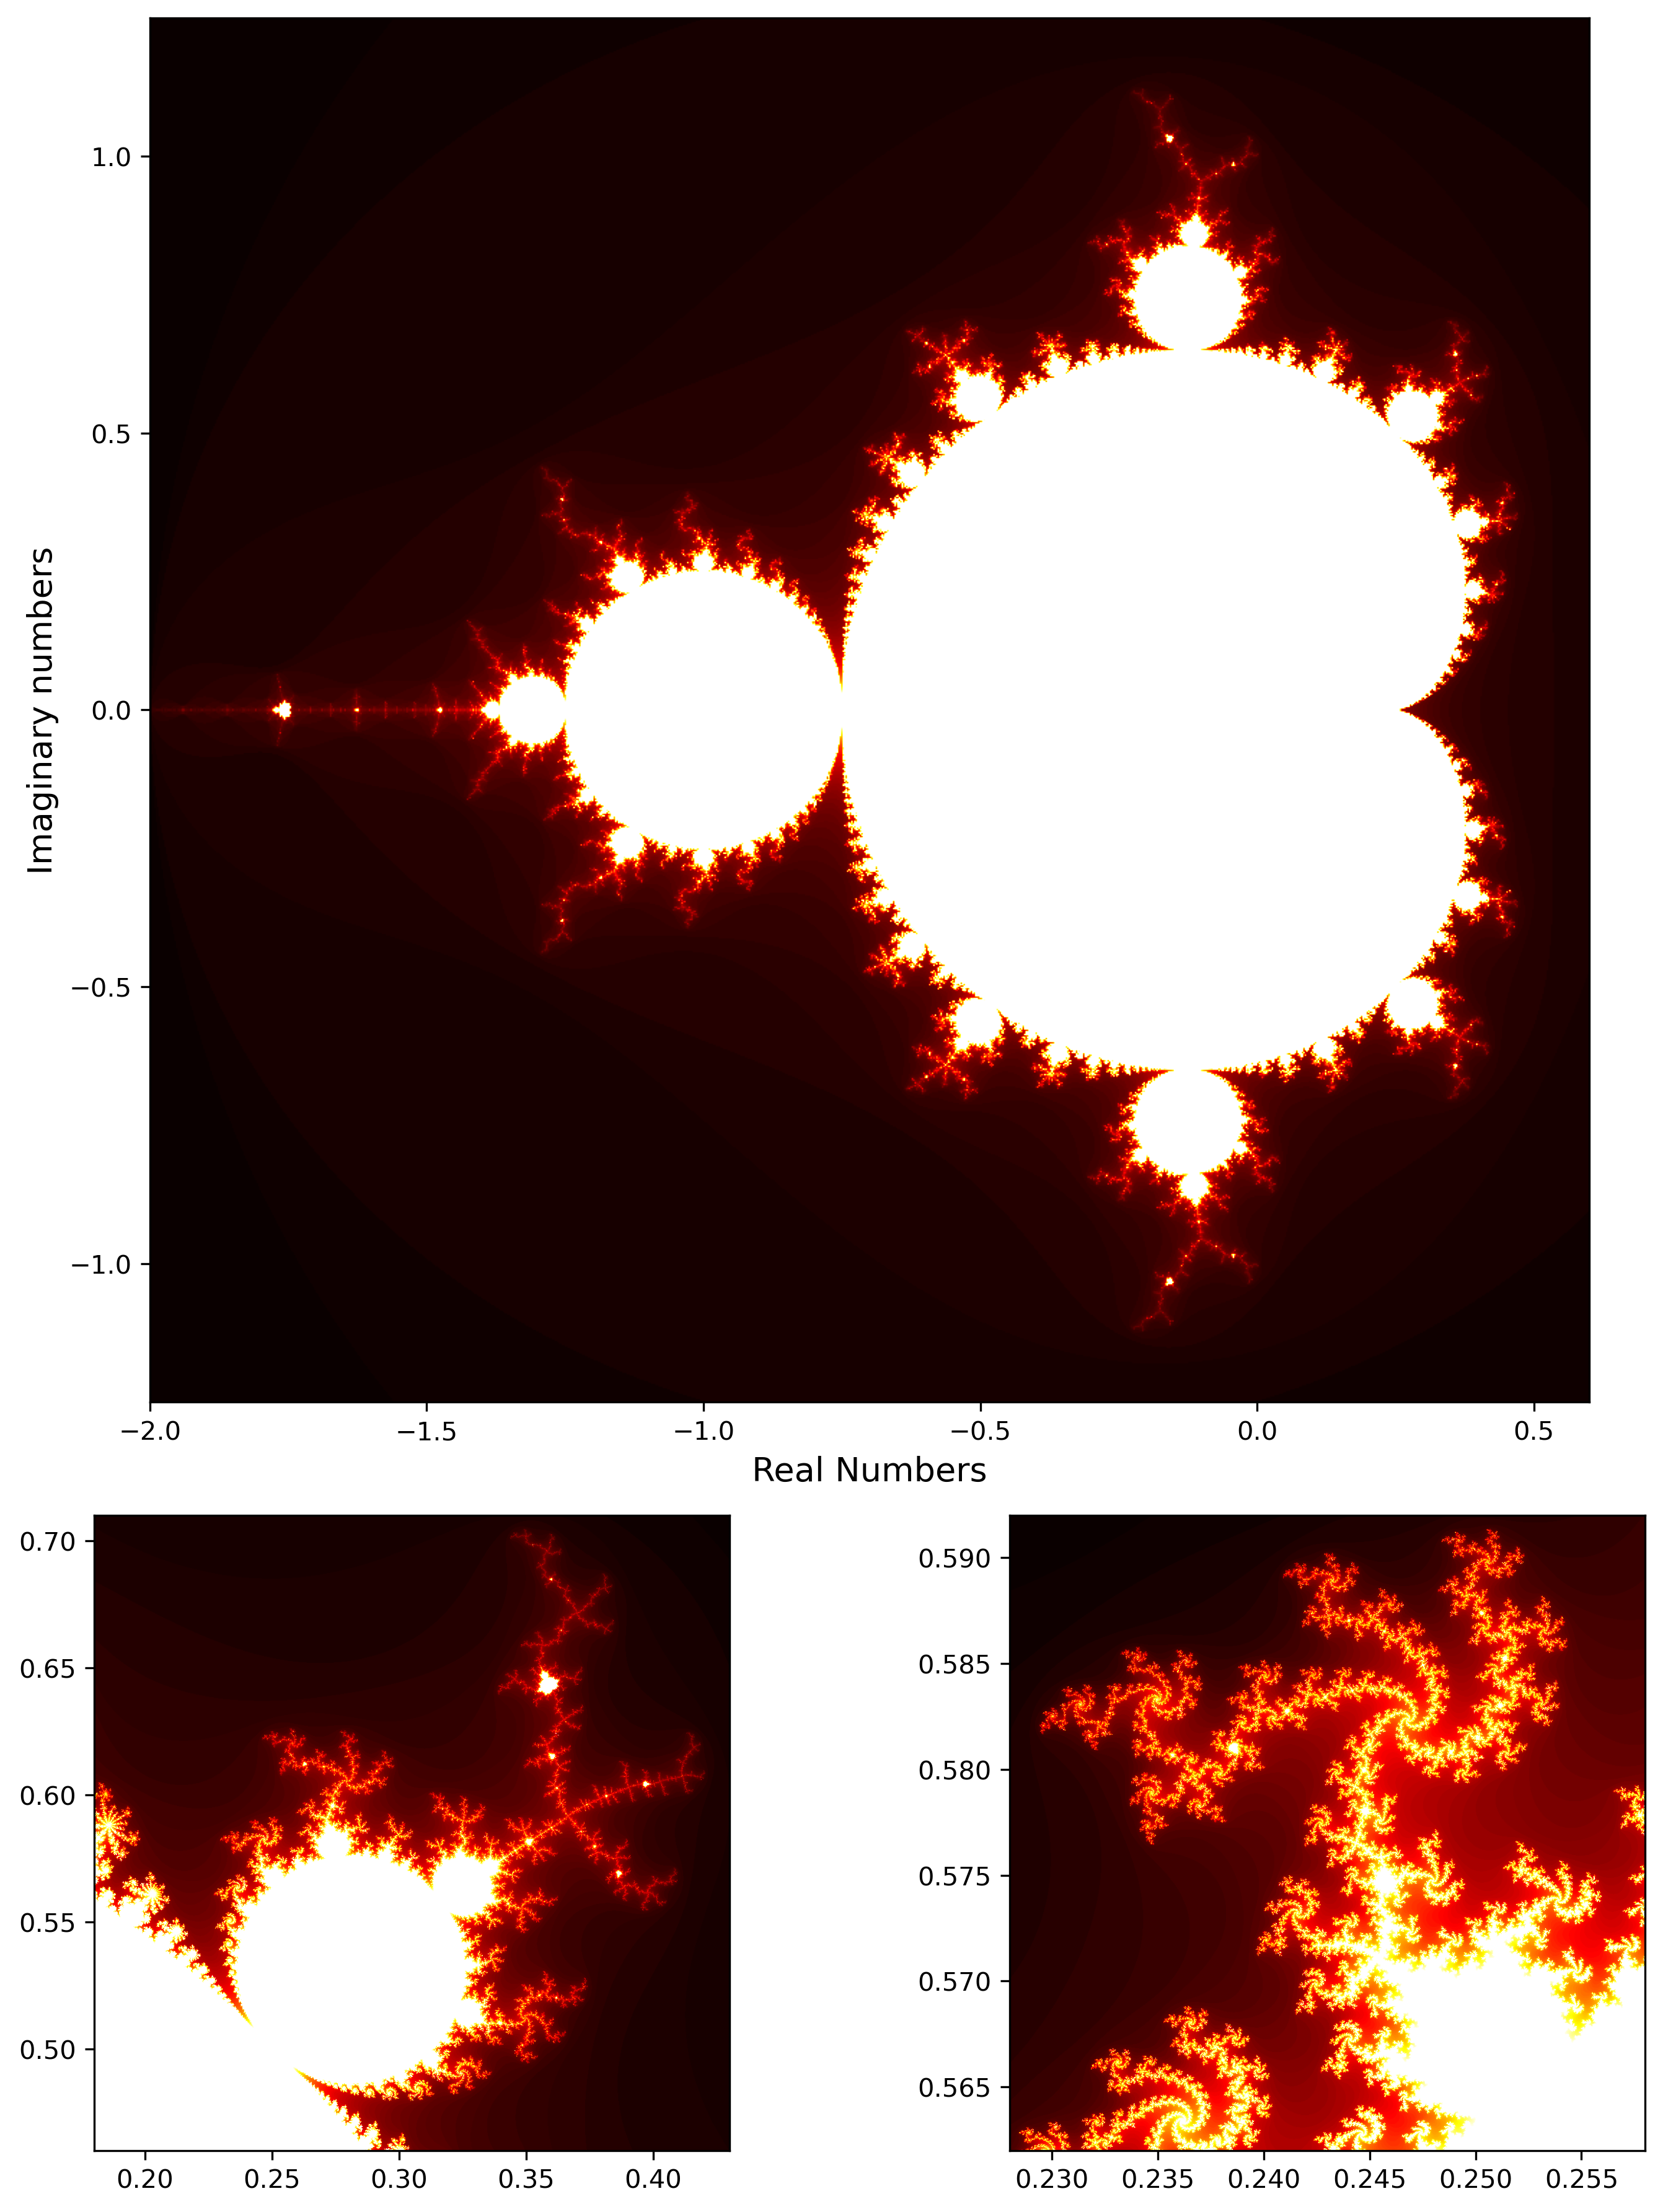

In [33]:
fig=  plt.figure(figsize=(10, 12), dpi=300)
gs = GridSpec(3, 2, fig)

# Main plot
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax1.imshow(mandelplot, cmap='hot', extent=[-2, 0.6, -1.25, 1.25])
ax1.set_ylabel('Imaginary numbers', fontsize=13)
ax1.set_xlabel('Real Numbers', fontsize=13)

# Zoom 1
ax2 = fig.add_subplot(gs[2, 0])
ax2.imshow(mandelplot_zoom, cmap='hot', extent=[0.18, 0.43, 0.46, 0.71], origin='lower')

# Zoom 2
ax3 = fig.add_subplot(gs[2, 1])
ax3.imshow(mandelplot_zoom2, cmap='hot', extent=[0.228, 0.258, 0.562, 0.592], origin='lower')

plt.tight_layout()
plt.show()

### Implementation of Sampler
---

In [22]:
class MBSampler:
    """
    A class used to sample points of the mandelbrot set for montecarlo sampling

    Attributes
    ----------
    re_min : float
        The lower bound of the real axis of the mandelbrot set
    re_max : float
        The upper bound of the real axis of the mandelbrot set
    im_min : float
        The lower bound of the imaginary axis of the mandelbrot set
    im_max : float
        The upper bound of the imaginary axis of the mandelbrot set

    Methods
    -------
    sample(method, num_samples, seed):
        Generates an given amount of complex numbers using a specified method that will use the seed given
    uniform_random(num_samples, seed):
        Generates an given amount of complex numbers using uniform random sampling with the given seed
    orthogonal(num_samples, seed):
        Generates an given amount of complex numbers using orthogonal sampling with the given seed
    latin_hypercube(num_samples, seed):
        Generates an given amount of complex numbers using orthogonal sampling with the given seed
    sobol(num_samples, seed):
        Generates an given amount of complex numbers using orthogonal sampling with the given seed
    """
    def __init__(self, re_min, re_max, im_min, im_max):
        self.bounds = {
            "re_min": re_min,
            "re_max": re_max,
            "im_min": im_min,
            "im_max": im_max
        }


    def sample(self, method, num_samples, seed):
        match method:
            case "UNIRAND":
                return self.uniform_random(num_samples, seed)
            case "OHC":
                return self.orthogonal(num_samples, seed)
            case "LHC":
                return self.latin_hypercube(num_samples, seed)
            case "SOBEL":
                return self.sobol(num_samples, seed)
            case _:
                raise ValueError("Unknown Sampling Method")

    def uniform_random(self, num_samples, seed):
        np.random.seed(seed)
        c_re = np.random.uniform(self.bounds["re_min"], self.bounds["re_max"], num_samples)
        c_im = np.random.uniform(self.bounds["im_min"], self.bounds["im_max"], num_samples)
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def orthogonal(self, num_samples, seed):
        orth = qmc.LatinHypercube(d=2, strength=2, seed=seed)
        samples = orth.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def latin_hypercube(self, num_samples, seed):
        lhc = qmc.LatinHypercube(d=2, seed=seed)
        samples = lhc.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

    def sobol(self, num_samples, seed):
        if not (num_samples and (num_samples & (num_samples - 1)) == 0):
            raise ValueError("For Sobol sampling, num_samples must be a power of 2.")
        sobol = qmc.Sobol(d=2, seed=seed)
        samples = sobol.random(n=num_samples)
        scaled_samples = qmc.scale(samples,
                                   [self.bounds["re_min"], self.bounds["im_min"]],
                                   [self.bounds["re_max"], self.bounds["im_max"]])
        c_re = scaled_samples[:, 0]
        c_im = scaled_samples[:, 1]
        c_array = c_re + 1j * c_im
        return c_array, c_re, c_im

In [7]:
def valid_sobol_sample_sizes(max_samples=1024):
    sample_sizes = []
    n = 1
    while 2 ** n <= max_samples:
        sample_sizes.append(2 ** n)
        n += 1
    return sample_sizes

In [23]:
def sobol_sample_sizes_generator(power=10):
    """Generates a list of the first 10 allowed numbers to be used for sobol sampling which are a power of 2.

    Args:
        power (int, optional): the highest power of 2 to be sampled from. Defaults to 10.

    Returns:
        list of int: a list of numbers from 2 to 2**power.
    """
    return [2**n for n in range(1,power+1)]

### Implementation of Monte Carlo
---

In [24]:
def monte_carlo_2(sample_range, num_iterations, max_length_set, re_min, re_max, im_min, im_max, sampling_method):
    all_iterations = np.zeros((num_iterations, len(sample_range)))

    for l in range(len(sample_range)):

        areas = np.zeros(num_iterations)
        area_integration_box = np.abs(re_max-re_min) * np.abs(im_max-im_min)
        n_samples = sample_range[l]

        for i in range(num_iterations):

            sampler = MBSampler(re_min=re_min, re_max=re_max, im_min=im_min, im_max=im_max)
            c_array, c_re, c_im = sampler.sample(method=sampling_method, num_samples=n_samples, seed=i)

            points_outside = 0
            for j in range(n_samples):
                z = complex(0,0)

                for k in range(max_length_set):
                    z = mandelbrot(z, c_array[j])
                    if magnitude_complex(z) > 2:
                        points_outside += 1
                        break

                areas[i] = area_integration_box * (1-(points_outside/n_samples))

        all_iterations[:, l] = areas

    return all_iterations

In [25]:
# Square of primes: 43**2 ~ 1800 samples
sample_range = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43])**2
sobol_sample = sobol_sample_sizes_generator(10)

random = monte_carlo_2(sample_range, 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND')
LHC = monte_carlo_2(sample_range, 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHC')
OS = monte_carlo_2(sample_range, 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='OHC')
sobol = monte_carlo_2(sobol_sample, 100, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='SOBEL')

Mean area random sampling: 1.5459734991887513
Mean area latin hypercube sampling: 1.5403136830719304
Mean area orthogonal sampling: 1.5457625743645216
Mean area sobel sampling: 1.5474951171875


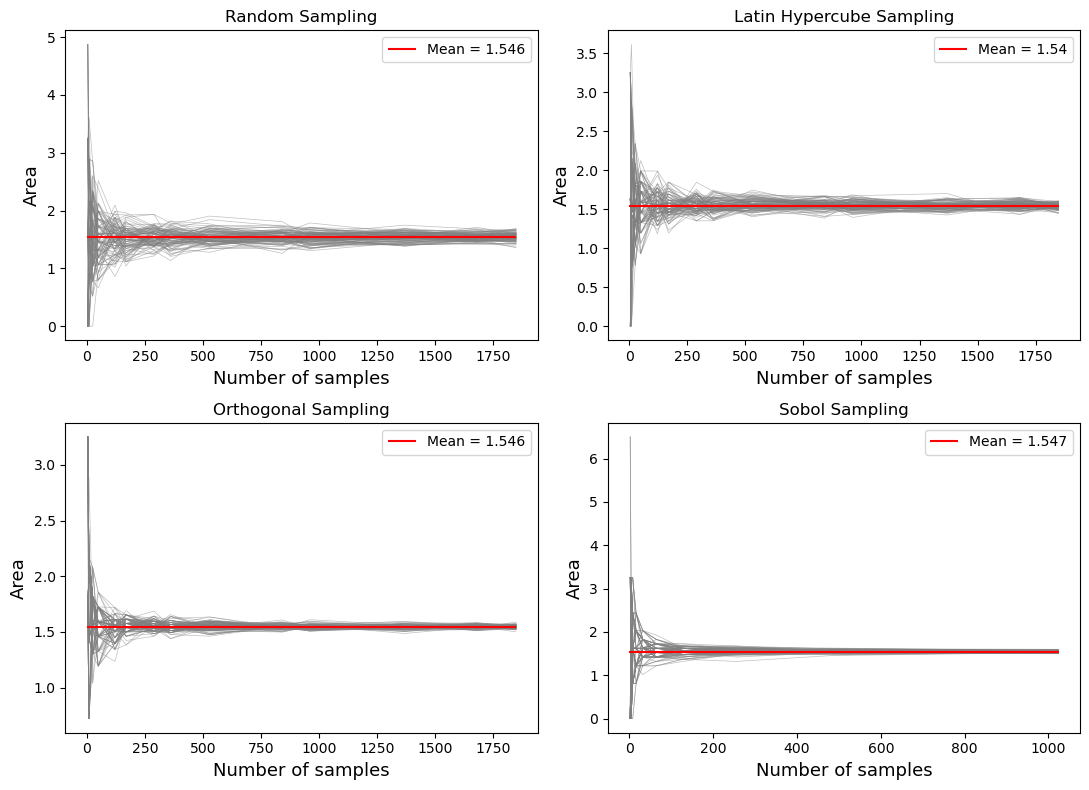

In [26]:
mean_area_random = np.mean(random[:, -1])
print(f'Mean area random sampling: {mean_area_random}')

mean_area_LHC = np.mean(LHC[:, -1])
print(f'Mean area latin hypercube sampling: {mean_area_LHC}')

mean_area_OS = np.mean(OS[:, -1])
print(f'Mean area orthogonal sampling: {mean_area_OS}')

mean_area_SOBOL = np.mean(sobol[:, -1])
print(f'Mean area sobel sampling: {mean_area_SOBOL}')

plt.figure(figsize=(11,8))

plt.subplot(2,2,1)
plt.title('Random Sampling')
for i in range(len(random)):
	plt.plot(sample_range, random[i, :], color='gray', lw=0.5, alpha=0.5)
plt.hlines(mean_area_random, xmin=0, xmax=sample_range[-1], color='red', label=f'Mean = {round(mean_area_random, 3)}')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

plt.subplot(2,2,2)
plt.title('Latin Hypercube Sampling')
for i in range(len(LHC)):
	plt.plot(sample_range, LHC[i, :], color='gray', lw=0.5, alpha=0.5)
plt.hlines(mean_area_LHC, xmin=0, xmax=sample_range[-1], color='red', label=f'Mean = {round(mean_area_LHC, 3)}')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

plt.subplot(2,2,3)
plt.title('Orthogonal Sampling')
for i in range(len(OS)):
	plt.plot(sample_range, OS[i, :], color='gray', lw=0.5, alpha=0.5)
plt.hlines(mean_area_OS, xmin=0, xmax=sample_range[-1], color='red', label=f'Mean = {round(mean_area_OS, 3)}')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

plt.subplot(2,2,4)
plt.title('Sobol Sampling')
for i in range(len(sobol)):
	plt.plot(sobol_sample, sobol[i, :], color='gray', lw=0.5, alpha=0.5)
plt.hlines(mean_area_SOBOL, xmin=0, xmax=sobol_sample[-1], color='red', label=f'Mean = {round(mean_area_SOBOL, 3)}')
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

plt.tight_layout()
plt.show()

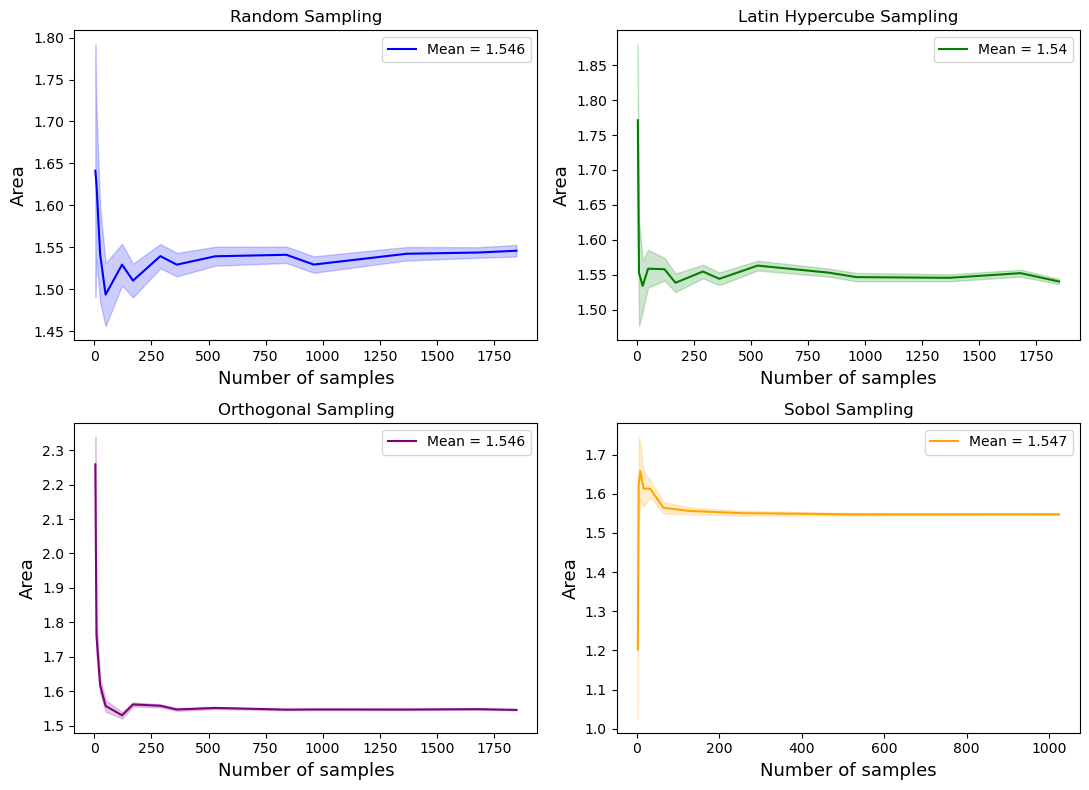

In [ ]:
# Calculate means and standard errors for each sampling method
mean_random = np.mean(random, axis=0)
std_error_random = np.std(random, axis=0) / np.sqrt(random.shape[0] - 1)

mean_LHC = np.mean(LHC, axis=0)
std_error_LHC = np.std(LHC, axis=0) / np.sqrt(LHC.shape[0] - 1)

mean_OS = np.mean(OS, axis=0)
std_error_OS = np.std(OS, axis=0) / np.sqrt(OS.shape[0] - 1)

mean_sobol = np.mean(sobol, axis=0)
std_error_sobol = np.std(sobol, axis=0) / np.sqrt(sobol.shape[0] - 1)

plt.figure(figsize=(11, 8))

# Random Sampling
plt.subplot(2, 2, 1)
plt.title('Random Sampling')
plt.plot(sample_range, mean_random, color='blue', label=f'Mean = {round(mean_area_random, 3)}')
plt.fill_between(sample_range, mean_random - std_error_random, mean_random + std_error_random, color='blue', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

# Latin Hypercube Sampling
plt.subplot(2, 2, 2)
plt.title('Latin Hypercube Sampling')
plt.plot(sample_range, mean_LHC, color='green', label=f'Mean = {round(mean_area_LHC, 3)}')
plt.fill_between(sample_range, mean_LHC - std_error_LHC, mean_LHC + std_error_LHC, color='green', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

# Orthogonal Sampling
plt.subplot(2, 2, 3)
plt.title('Orthogonal Sampling')
plt.plot(sample_range, mean_OS, color='purple', label=f'Mean = {round(mean_area_OS, 3)}')
plt.fill_between(sample_range, mean_OS - std_error_OS, mean_OS + std_error_OS, color='purple', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

# Sobol Sampling
plt.subplot(2, 2, 4)
plt.title('Sobol Sampling')
plt.plot(sobol_sample, mean_sobol, color='orange', label=f'Mean = {round(mean_area_SOBOL, 3)}')
plt.fill_between(sobol_sample, mean_sobol - std_error_sobol, mean_sobol + std_error_sobol, color='orange', alpha=0.2)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.legend()

plt.tight_layout()
plt.show()


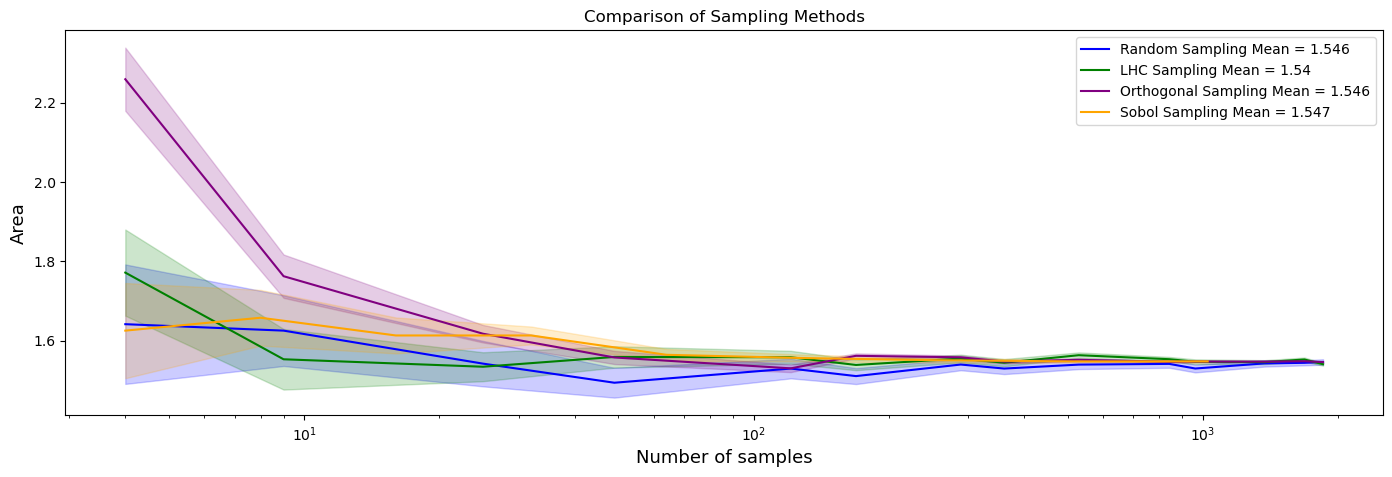

In [32]:
# Plot all in one figure
plt.figure(figsize=(17, 5))

# Random Sampling
plt.plot(sample_range, mean_random, color='blue', label=f'Random Sampling Mean = {round(mean_area_random, 3)}')
plt.fill_between(sample_range, mean_random - std_error_random, mean_random + std_error_random, color='blue', alpha=0.2)

# Latin Hypercube Sampling
plt.plot(sample_range, mean_LHC, color='green', label=f'LHC Sampling Mean = {round(mean_area_LHC, 3)}')
plt.fill_between(sample_range, mean_LHC - std_error_LHC, mean_LHC + std_error_LHC, color='green', alpha=0.2)

# Orthogonal Sampling
plt.plot(sample_range, mean_OS, color='purple', label=f'Orthogonal Sampling Mean = {round(mean_area_OS, 3)}')
plt.fill_between(sample_range, mean_OS - std_error_OS, mean_OS + std_error_OS, color='purple', alpha=0.2)

# Sobol Sampling
plt.plot(sobol_sample[1:], mean_sobol[1:], color='orange', label=f'Sobol Sampling Mean = {round(mean_area_SOBOL, 3)}')
plt.fill_between(sobol_sample[1:], mean_sobol[1:] - std_error_sobol[1:], mean_sobol[1:] + std_error_sobol[1:], color='orange', alpha=0.2)

# Adding labels, title, and legend
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Area', fontsize=13)
plt.title('Comparison of Sampling Methods')
plt.xscale('log')
plt.legend()
plt.show()

In [11]:
def monte_carlo(num_iterations, num_samples, convergence_criterion, re_min, re_max, im_min, im_max, sampling_method='random'):
    # Initialize arrays to store areas and sampling points
    areas = np.zeros((num_iterations, num_samples))
    sampling = np.zeros((num_iterations, num_samples, 3))  # Stores real and imaginary parts, and if inside the set

    # Calculate the area of the integration box
    area_integration_box = np.abs(re_max - re_min) * np.abs(im_max - im_min)

    for i in range(num_iterations):
        # Sample points using the provided MBSampler instance
        sampler = MBSampler(re_min, re_max, im_min, im_max)
        c_array, c_re, c_im = sampler.sample(num_samples=num_samples, method=sampling_method, seed = i)

        points_inside = 0
        for j in range(num_samples):
            z = complex(0, 0)
            in_set = True

            # Manual convergence check
            for k in range(convergence_criterion):
                z = z**2 + c_array[j]
                if abs(z) > 2:
                    in_set = False
                    break

            sampling[i, j, :] = c_re[j], c_im[j], int(in_set)
            points_inside += int(in_set)

        # Calculate area estimate for this iteration
            areas[i,j] = area_integration_box * ((points_inside/(num_samples)))

    return areas, sampling



In [12]:
def monte_carlo(num_iterations, num_samples, max_length_set, re_min, re_max, im_min, im_max, sampling_method='random'):
    #max length set hernoemen naar convergence criterium
    # num iterations is the number of times the same number of samples is repeated for an average
    areas = np.ndarray(shape=(num_iterations, num_samples))
    # on the third dimension, the coordinates are stored in the [a,b,0] (real) and [a,b,1](imaginary) and if it is within the set, store a 1 (if not a 0) on [,,3]
    sampling = np.ndarray(shape=(num_iterations, num_samples, 3))  # on the third dimension, the coordinates are stored in the [,,0] and [,,1] and if it is within the set, store a 1 (if not a 0) on [,,3]
    area_integration_box = np.abs(re_max-re_min) * np.abs(im_max-im_min)   # suggestion np. abs after the product is sufficient

    for i in range(num_iterations):
        sampler = MBSampler(re_min, re_max, im_min, im_max)
        c_array, c_re, c_im = sampler.sample(num_samples=num_samples, method=sampling_method, seed = i)

        points_outside = 0
        for j in range(num_samples):
            z = complex(0,0)

            for k in range(max_length_set):
                z = mandelbrot(z, c_array[j])
                if magnitude_complex(z) > 2:
                    sampling[i, j, :] = c_re[j], c_im[j], 0
                    points_outside = points_outside + 1
                    break
                sampling[i, j, :] = c_re[j], c_im[j], 1
            print
            print((points_outside/num_samples))
            areas[i, j] = area_integration_box * (1-(points_outside/num_samples))


    return areas, sampling

### Visualizing Monte Carlo Hit and Miss

In [13]:
# Parameters
num_samples = 200

In [14]:
area_mc_sampling = monte_carlo(num_iterations=20, num_samples=20, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND')
_, samples = area_mc_sampling

0.05
0.05
0.05
0.1
0.15
0.15
0.2
0.25
0.3
0.3
0.3
0.35
0.35
0.4
0.45
0.5
0.55
0.55
0.6
0.6
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.55
0.6
0.6
0.65
0.65
0.7
0.75
0.8
0.85
0.0
0.05
0.05
0.1
0.15
0.15
0.2
0.25
0.3
0.35
0.35
0.4
0.45
0.45
0.5
0.5
0.55
0.55
0.6
0.65
0.05
0.05
0.1
0.15
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.6
0.65
0.7
0.7
0.75
0.8
0.05
0.1
0.15
0.2
0.2
0.25
0.3
0.35
0.4
0.4
0.4
0.45
0.45
0.5
0.55
0.55
0.6
0.65
0.7
0.75
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.55
0.6
0.65
0.7
0.75
0.8
0.8
0.8
0.85
0.05
0.1
0.15
0.2
0.25
0.25
0.3
0.35
0.35
0.4
0.45
0.5
0.55
0.55
0.55
0.6
0.65
0.7
0.75
0.75
0.05
0.1
0.15
0.15
0.2
0.25
0.25
0.3
0.35
0.35
0.4
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.05
0.1
0.15
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.5
0.5
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.7
0.75
0.8
0.85
0.85
0.85
0.0
0.05
0.05
0.05
0.05
0.1
0.15
0.15
0.2
0.25
0.25
0.3
0.35
0.4
0.45
0.45
0.5
0.55
0.6
0.6


In [15]:
samples

array([[[-0.57308489,  1.19654586,  0.        ],
        [-0.14050765,  0.74789641,  1.        ],
        [-0.43281522, -0.09630159,  1.        ],
        ...,
        [ 0.1648116 ,  0.29233499,  1.        ],
        [ 0.02320755,  1.1093702 ,  0.        ],
        [ 0.26203159,  0.45455075,  1.        ]],

       [[-0.91574279,  0.75186142,  0.        ],
        [-0.12715632,  1.17065394,  0.        ],
        [-1.99970263, -0.46643955,  0.        ],
        ...,
        [-0.54740645,  0.83656418,  0.        ],
        [-1.63499396, -1.20427931,  0.        ],
        [-1.48493613,  0.62536079,  0.        ]],

       [[-0.86641325,  0.01311523,  1.        ],
        [-1.9325918 , -1.08678374,  0.        ],
        [-0.57087756, -0.17969418,  1.        ],
        ...,
        [-0.71498422,  0.20001045,  1.        ],
        [ 0.20105986, -0.8442535 ,  0.        ],
        [-1.79292176,  0.50188087,  0.        ]],

       ...,

       [[-1.23387099, -0.5056857 ,  0.        ],
        [-0

In [16]:
# Take a single sample from Monte Carlo
sample = samples[0]  #? does this not rather give a single iteration or is it ignored due to it being 1?
x0, y0 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 1, :2] ]) #suggestion x0 = mc_in_area_x etc.
x1, y1 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 0, :2] ]) #suggestion x1 = mc_out_area_x etc.

In [17]:
num_iter = 50
area_mc,_ = monte_carlo(num_iterations=num_iter, num_samples=num_samples, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='UNIRAND')
duration = range(num_samples)  # duration to sample_size_mc, but also why a seperate variable

0.0
0.0
0.0
0.005
0.01
0.015
0.02
0.02
0.025
0.03
0.035
0.04
0.04
0.045
0.05
0.055
0.06
0.06
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.125
0.13
0.135
0.135
0.135
0.135
0.14
0.14
0.145
0.15
0.15
0.155
0.155
0.155
0.16
0.165
0.17
0.17
0.17
0.175
0.18
0.185
0.19
0.195
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.32
0.325
0.33
0.335
0.335
0.34
0.345
0.35
0.355
0.355
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.445
0.45
0.45
0.45
0.455
0.455
0.455
0.46
0.465
0.465
0.47
0.47
0.475
0.48
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.515
0.515
0.515
0.52
0.52
0.525
0.525
0.53
0.535
0.54
0.545
0.55
0.55
0.555
0.56
0.565
0.57
0.57
0.575
0.575
0.575
0.58
0.585
0.59
0.59
0.595
0.595
0.595
0.6
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.66
0.665
0.67
0.67
0.675
0.68

In [18]:
area_mc[:,0]

array([6.5   , 6.4675, 6.5   , 6.4675, 6.4675, 6.4675, 6.5   , 6.4675,
       6.5   , 6.4675, 6.4675, 6.4675, 6.4675, 6.4675, 6.4675, 6.4675,
       6.4675, 6.5   , 6.4675, 6.4675, 6.5   , 6.4675, 6.4675, 6.4675,
       6.4675, 6.4675, 6.4675, 6.4675, 6.4675, 6.5   , 6.5   , 6.4675,
       6.5   , 6.4675, 6.4675, 6.4675, 6.5   , 6.4675, 6.4675, 6.5   ,
       6.4675, 6.4675, 6.4675, 6.4675, 6.4675, 6.4675, 6.5   , 6.4675,
       6.4675, 6.4675])

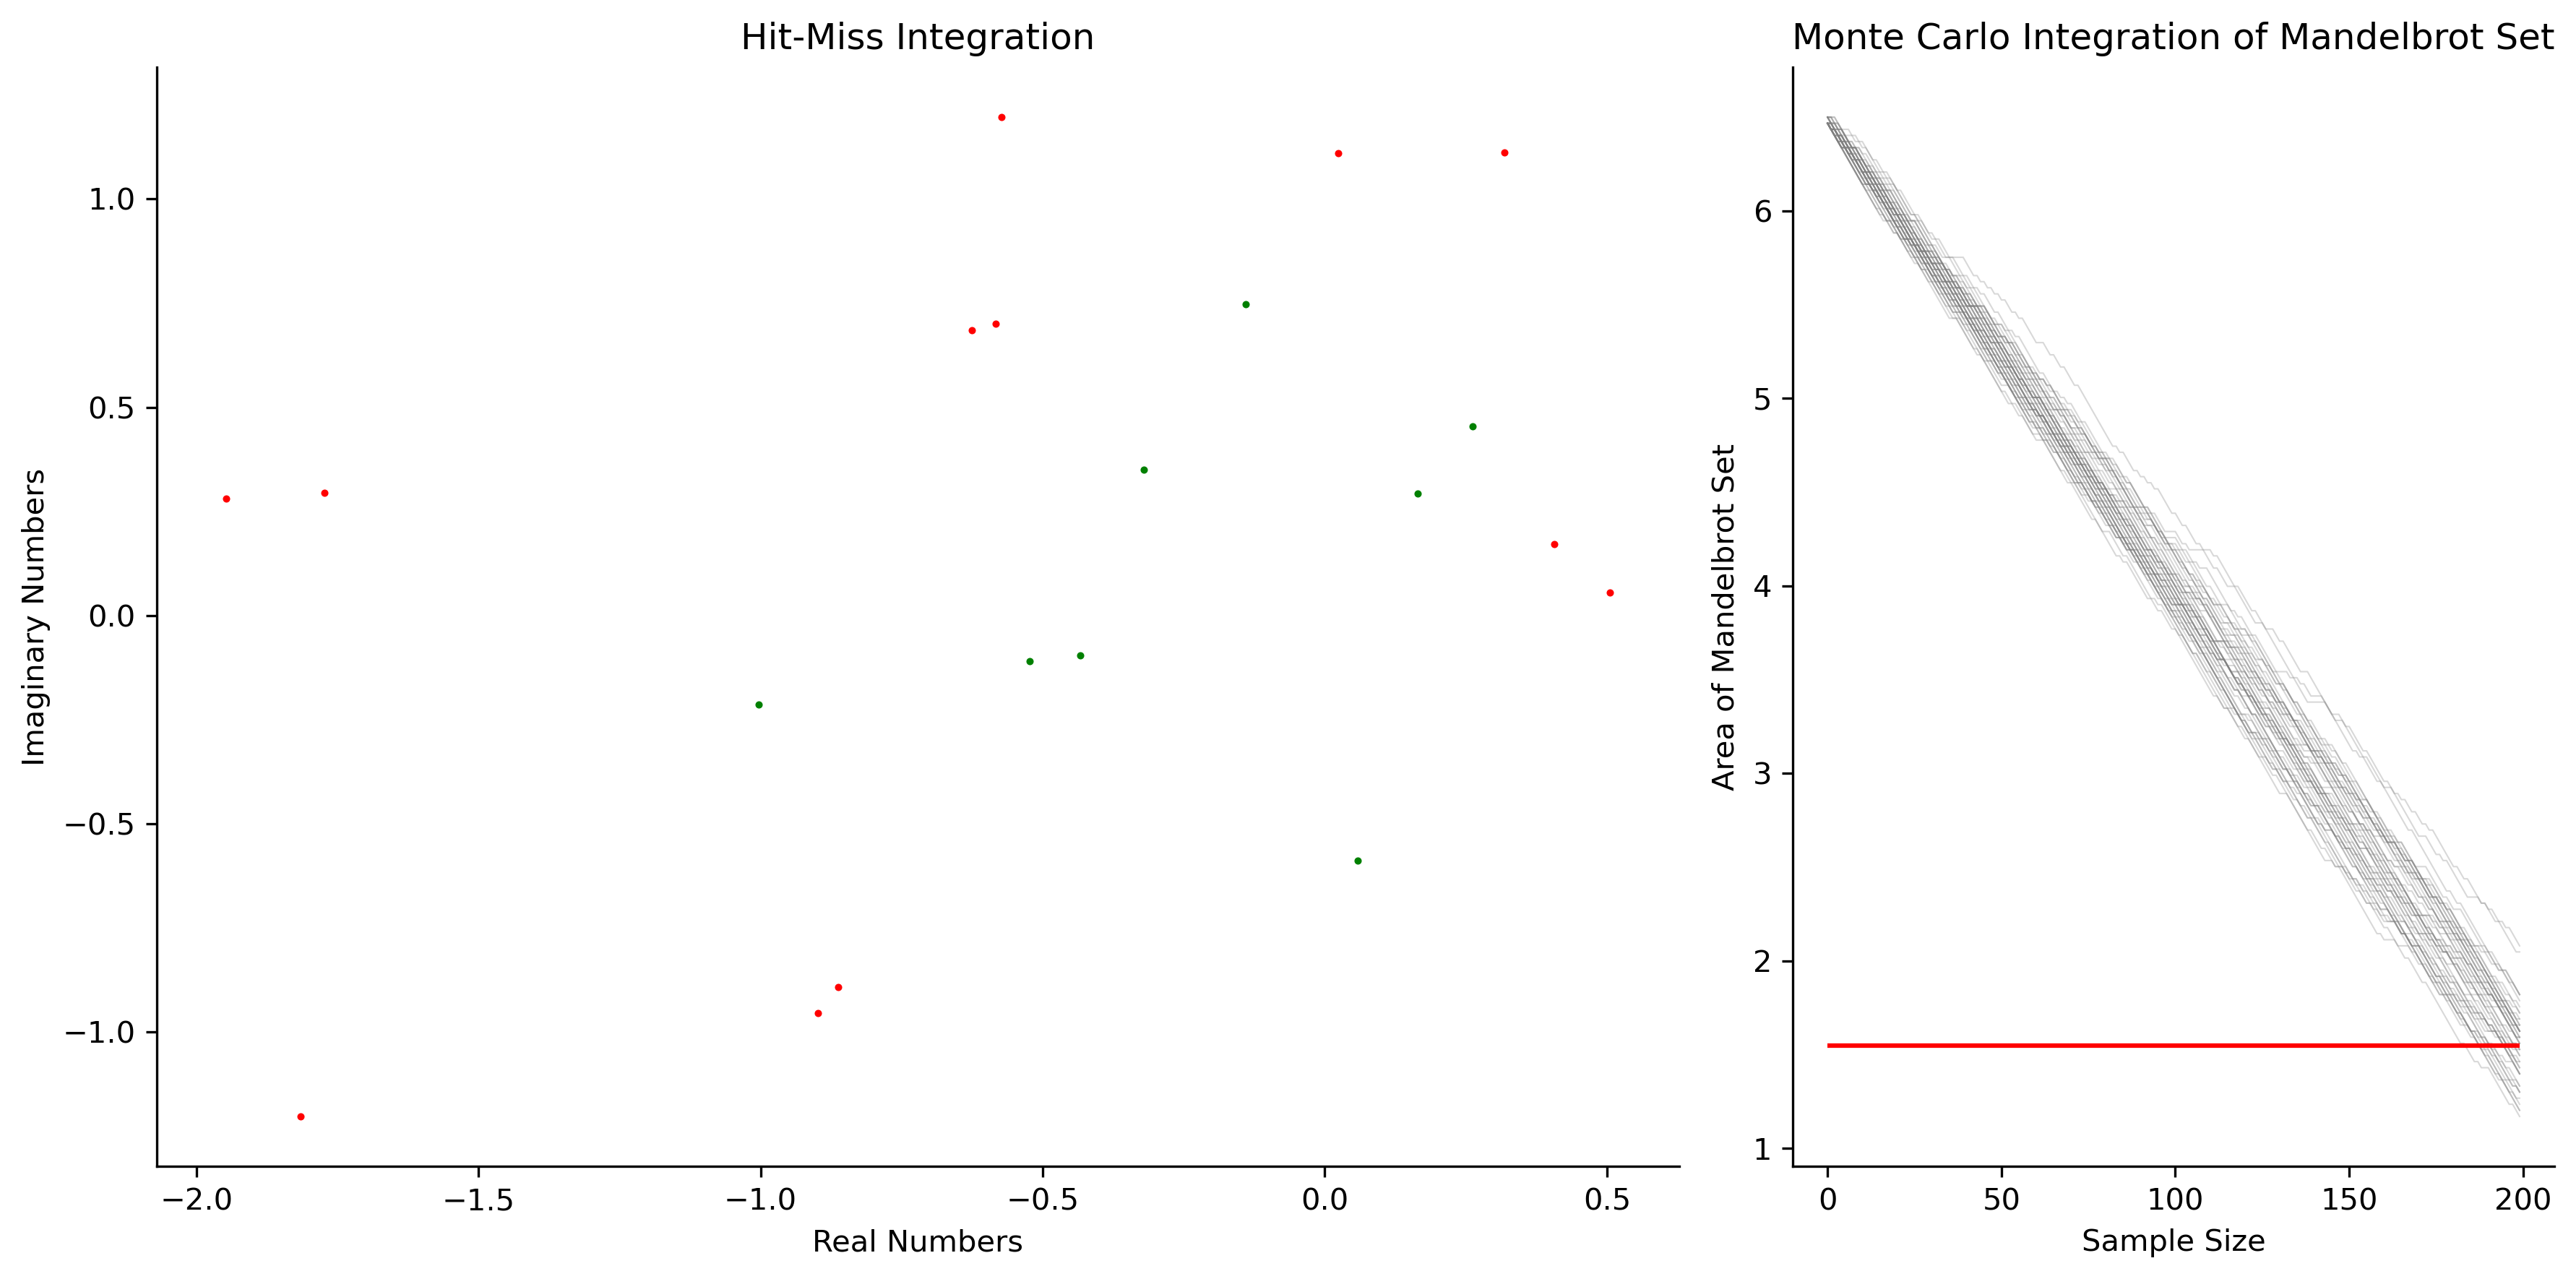

In [19]:
# Create a figure and use GridSpec to control the plot size ratios
fig = plt.figure(figsize=(12, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)  # Set width ratio to make second plot smaller

# Subplot 1: Line plot for infection peak reduction
ax1 = fig.add_subplot(gs[0])


ax1.scatter(x = x0, y= y0, color = 'green', s=2)
ax1.scatter(x = x1, y= y1, color = 'red', s=2)

ax1.set_title('Hit-Miss Integration', fontsize=12) #idk of hit-miss de passende naam is? dat nog uitzoeken of zeg mc area simulation mandelbrot
ax1.set_xlabel('Real Numbers')  # real axis
ax1.set_ylabel('Imaginary Numbers') # imaginary axis

ax2 = fig.add_subplot(gs[1])
for i in range(num_iter):
    ax2.plot(duration, area_mc[i], alpha=0.3, color = 'grey', lw =0.5)
#ax2.clabel(contours, inline=True, fontsize=8)
ax2.hlines(np.mean(area_mc[:,num_samples-1]), xmin=0, xmax=num_samples-1, color = 'red') #mby de echte opzoeken op het internet)

ax2.set_ylabel("Area of Mandelbrot Set")
ax2.set_xlabel("Sample Size")
ax2.set_title("Monte Carlo Integration of Mandelbrot Set")

# Remove unnecessary spines from both subplots
#? what is a spine?
#ans: Spines are the black lines at the top and right of the plot. It has nothing to do with the simulations. Its visually different ~ Job
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure with high resolution (300 DPI)
plt.savefig('combined_plot_with_labels.png', dpi=300)
plt.show()

In [20]:
area_mc

array([[6.5   , 6.5   , 6.5   , ..., 1.6575, 1.625 , 1.5925],
       [6.4675, 6.4675, 6.435 , ..., 1.7875, 1.7875, 1.755 ],
       [6.5   , 6.4675, 6.435 , ..., 1.7225, 1.69  , 1.69  ],
       ...,
       [6.4675, 6.435 , 6.435 , ..., 1.6575, 1.625 , 1.5925],
       [6.4675, 6.4675, 6.435 , ..., 1.625 , 1.5925, 1.56  ],
       [6.4675, 6.435 , 6.4025, ..., 1.885 , 1.8525, 1.82  ]])

In [21]:
np.mean(area_mc[:,-1])

1.54635

In [22]:
area_mc[:, -1]

array([1.5925, 1.755 , 1.69  , 1.5275, 1.82  , 1.43  , 1.5925, 1.3   ,
       1.56  , 1.495 , 1.5275, 1.625 , 1.2675, 1.3325, 1.56  , 1.2025,
       1.3   , 1.7225, 1.82  , 1.235 , 1.3975, 1.5275, 2.0475, 1.3975,
       1.4625, 2.08  , 1.6575, 1.625 , 1.3325, 1.625 , 1.3975, 1.17  ,
       1.625 , 1.6575, 1.3   , 1.625 , 1.43  , 1.495 , 1.7225, 1.69  ,
       1.7875, 1.5925, 1.4625, 1.6575, 1.625 , 1.2025, 1.3975, 1.5925,
       1.56  , 1.82  ])